## 05.1 Spatiotemporal Data: Navigating NetCDF Files

In this notebook, we explore the contents of a single NetCDF file. The file contains output from one year of a 30-year simulation of historical climate in southwestern Idaho, over a domain that contains the entirety of the Boise River Basin (Upper and Lower). 

The purpose of this notebook is to build a working conceptual model of the hierarchical organization of NetCDF files – to develop an understanding of how 'Dimensions', 'Coordinates', and 'Data variables' relate to one another. The key takeaway of this notebook is to understand that NetCDF is a powerful file format for organizing data (be it from models or observations) that vary in at least one dimension. In this case, we will be dealing with three dimensional data that varies in two dimensions of space (east-west and south-north, or longitude and latitude) and one in time. 

The data we'll be working with is from simulations using the [Weather Research and Forecasting (WRF) model](https://www.mmm.ucar.edu/models/wrf) that were done in my lab. WRF is a powerful model to simulate coupled land-atmosphere dynamics for weather forecasting, climate downscaling, and other research and practical applications. WRF is, for example, the backbone of the NOAA High Resolution Rapid Refresh (HRRR) model that many of you may know. Our research group carried out a 30-year simulation of historical climate over southwest Idaho, providing us a spatiotemporally complete estimate of weather and climate conditions at a spatial resolution of 1 km and a temporal resolution of 1 hr. The outputs of the WRF model are copious, and so we developed subsets of this simulation to support a variety of applications. The subset we will be working with today is daily surface hydrometeorlogical conditions (precipitation, temperature, humidity, and solar radiation) for water year 2017, the so-called "Snowmageddon" year. 

Throughout this unit we'll be using the `xarray` library, an insanely helpful library for dealing with data that is stored as NetCDF files. We will use `xarray` to open two files – the daily climate data for water year 2017 and some geographic variables for the modeling domain – and perform a couple of analyses, from which we will create some plots. The primary things we want to learn from the notebook today is:

- How to use `xarray` to open a single NetCDF file,
- How to explore the contents of that NetCDF file using `xarray`,
- How to retrieve data from the NetCDF file, and
- How to access the spatial and temporal elements of the data.

### 1. Imports and Definitions

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Latitude and longitude of Mores Creek Summit Snotel site obtained from the NRCS Snotel site info
mc_lat = 43 + 56/60 # Mores Creek Summit Snotel latitude
mc_lon = -(115 + 40/60) # Mores Creek Summit Snotel longitude

wrf_geofile = '../data/wrf_geoinfo.nc' # WRF geographic info file
wrf_ncfile = '../data/WRF-NARR-1km-WY2017.nc' # WRF output NetCDF file of daily data for WY2017


### 2. Open and Explore the NetCDF Files

Opening a single NetCDF file using `xarray` is straightforward enough. The library "loads" the content of the file into an `xarray DataSet`. Ordinarily, we append `ds` to the name of the variable to denote that it's a dataset `xarray DataSet`. We can then have Python report to use what the contents of the dataset are. Let's open the file with the climate data first. 

In [ ]:
wrf_ds = xr.open_dataset(wrf_ncfile) # Open the WRF NetCDF file
wrf_ds # Display the dataset information

<xarray.Dataset> Size: 1GB
Dimensions:  (XTIME: 365, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 3kB 2016-10-01 2016-10-02 ... 2017-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 166MB ...
    TMEAN    (XTIME, south_north, west_east) float32 166MB ...
    Q2       (XTIME, south_north, west_east) float32 166MB ...
    SWDOWN   (XTIME, south_north, west_east) float32 166MB ...
    SWNORM   (XTIME, south_north, west_east) float32 166MB ...
    TMIN     (XTIME, south_north, west_east) float32 166MB ...
    TMAX     (XTIME, south_north, west_east) float32 166MB ...

Now let's open the file containing the geographic information.

In [14]:
wrf_geods = xr.open_dataset(wrf_geofile)
wrf_geods

<xarray.Dataset> Size: 33MB
Dimensions:  (Time: 24, south_north: 327, west_east: 348)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 11MB ...
    XLONG    (Time, south_north, west_east) float32 11MB ...
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    HGT      (Time, south_north, west_east) float32 11MB ...
Attributes: (12/135)
    TITLE:                            OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                      1987-10-01_00:00:00
    SIMULATION_START_DATE:           1987-09-16_00:00:00
    WEST-EAST_GRID_DIMENSION:        349
    SOUTH-NORTH_GRID_DIMENSION:      328
    BOTTOM-TOP_GRID_DIMENSION:       50
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    history:                         Sun May 26 22:18:29 2019: ncks -v XLAT,X...
    NCO:                             4.6.9

### 3. Get the Index Closest to the Mores Creek Snotel Site

In [21]:
# Calculate the distance from each grid point to Mores Creek Summit
# Using the Euclidean distance as an approximation
distance = np.sqrt((wrf_geods['XLAT'][0,:,:].values - mc_lat)**2 + 
                   (wrf_geods['XLONG'][0,:,:].values - mc_lon)**2)

# Find the indices of the minimum distance
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
row, col = min_idx

print(f"Closest grid point to Mores Creek Summit:")
print(f"Row: {row}, Column: {col}")
print(f"Grid Latitude: {wrf_geods['XLAT'][0,row, col]:.4f}")
print(f"Grid Longitude: {wrf_geods['XLONG'][0,row, col]:.4f}")
print(f"Distance: {distance[row, col]:.4f} degrees")

Closest grid point to Mores Creek Summit:
Row: 144, Column: 170
Grid Latitude: 43.9362
Grid Longitude: -115.6618
Distance: 0.0056 degrees


### 4. Get Point-scale Time Series Data

In [22]:
mc_dates = wrf_ds['XTIME'][:].values
mc_precip = wrf_ds['DPRCP'][:, row, col].values
mc_tmean = wrf_ds['TMEAN'][:, row, col].values
mc_tmin = wrf_ds['TMIN'][:, row, col].values
mc_tmax = wrf_ds['TMAX'][:, row, col].values

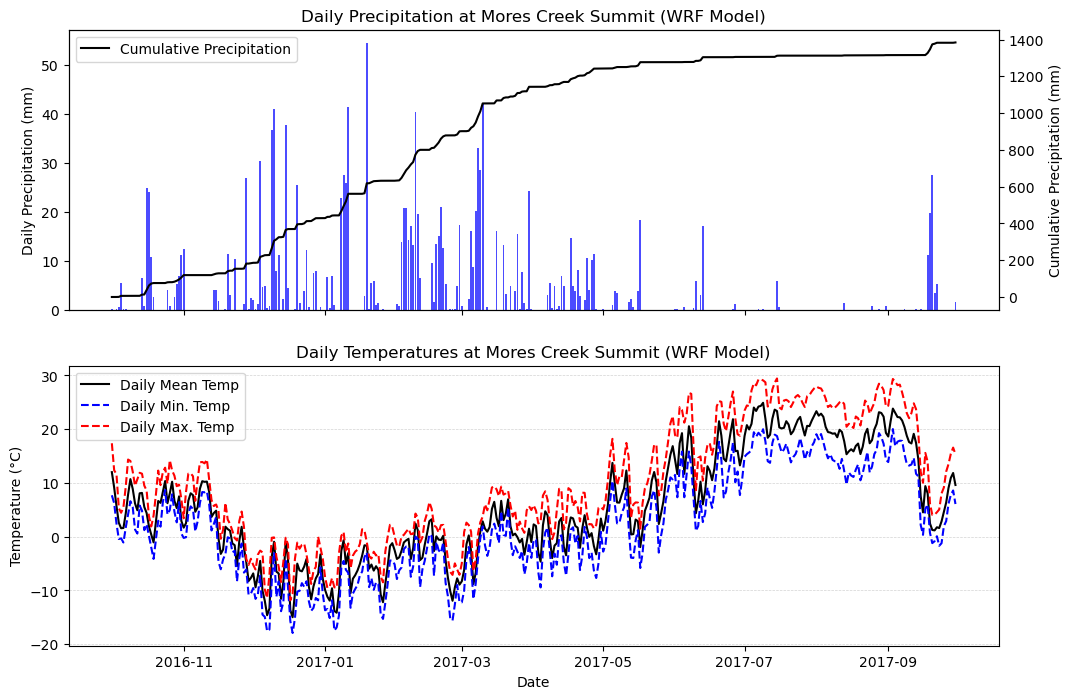

In [56]:
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

ax[0].bar(mc_dates, mc_precip, width=0.8, color='blue', alpha=0.7)
ax[0].set_ylabel('Daily Precipitation (mm)')
ax[0].set_title('Daily Precipitation at Mores Creek Summit (WRF Model)')
ax_cp = ax[0].twinx()
ax_cp.plot(mc_dates, np.cumsum(mc_precip), color='black', label='Cumulative Precipitation')
ax_cp.set_ylabel('Cumulative Precipitation (mm)')
ax_cp.legend(loc='upper left')
ax[1].plot(mc_dates, mc_tmean - 273.15, label='Daily Mean Temp', color='black')
ax[1].plot(mc_dates, mc_tmin - 273.15, label='Daily Min. Temp', color='blue', linestyle='--')
ax[1].plot(mc_dates, mc_tmax - 273.15, label='Daily Max. Temp', color='red', linestyle='--')
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title('Daily Temperatures at Mores Creek Summit (WRF Model)')
ax[1].legend()
ax[1].grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5)
ax[1].set_xlabel('Date')

plt.show()

### 5. Get the Annual Total Precipitation and Plot 

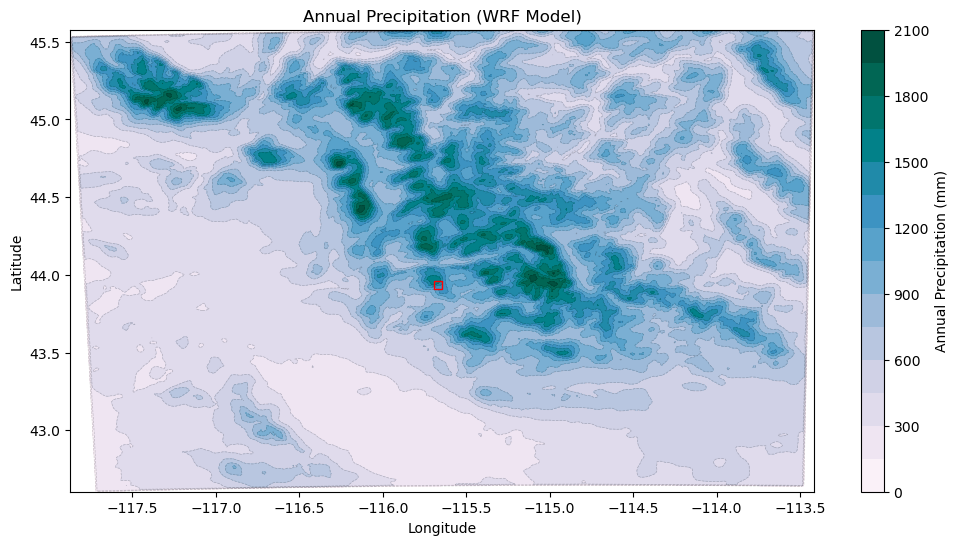

In [50]:
ann_precip = wrf_ds['DPRCP'].sum(dim='XTIME')

plt.figure(figsize=(12,6))
plt.contour(wrf_geods['XLONG'][0,:,:], wrf_geods['XLAT'][0,:,:], ann_precip, 
            levels=15, colors='black', linestyles='dashed', linewidths=0.5, alpha=0.2)
plt.contourf(wrf_geods['XLONG'][0,:,:], wrf_geods['XLAT'][0,:,:], ann_precip, 
             levels=15, cmap='PuBuGn')
plt.plot(mc_lon, mc_lat, marker='s', markeredgecolor='red', 
         markerfacecolor='none', markersize=6, label='Mores Creek Summit')
plt.colorbar(label='Annual Precipitation (mm)')
plt.title('Annual Precipitation (WRF Model)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

What does the spatial distribution of precipitation look like? Does it conform to our expectation that precipitation goes with topography?

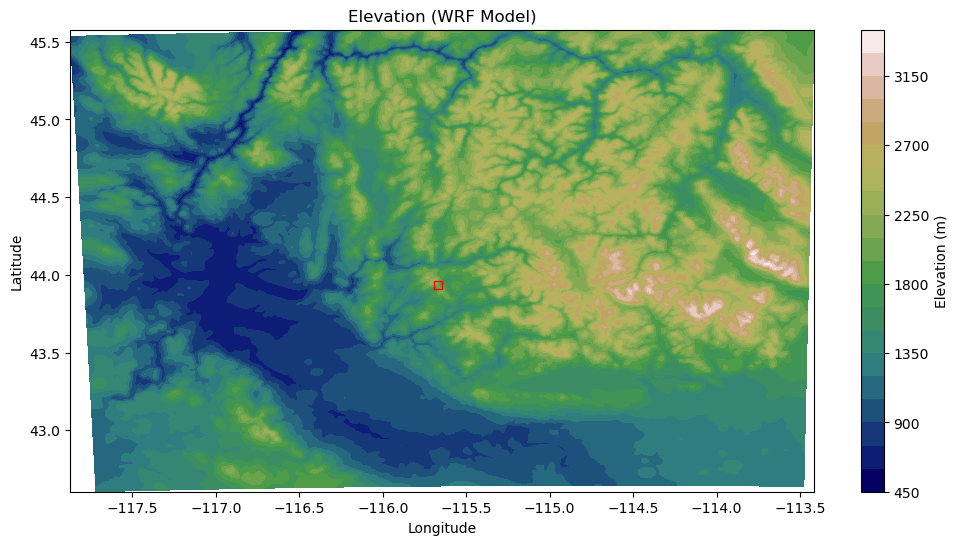

In [ ]:
elev = wrf_geods['HGT'][0,:,:]

plt.figure(figsize=(12,6))
plt.contourf(wrf_geods['XLONG'][0,:,:], wrf_geods['XLAT'][0,:,:], elev, 
             levels=20, cmap='gist_earth')
plt.plot(mc_lon, mc_lat, marker='s', markeredgecolor='red', 
         markerfacecolor='none', markersize=6, label='Mores Creek Summit')
plt.colorbar(label='Elevation (m)')
plt.title('Elevation (WRF Model)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Challenge: Plot Other Variables

Try one or more of these next steps:

* Spatial distribution of average mean daily temperature (easy)
* Spatial distribution of average daily temperature range (intermediate)
* Spatial distribution of estimated fraction of precipitation as snow based on one assumption (hard)

#### Reflection Questions:

* Just because our data varies in three dimensions does not mean that data that varies in additional dimensions cannot be stored in NetCDF files. Indeed, NetCDF is a great protocol for data varying in 4 and even more dimensions. Can you think about and discuss other variables that might vary in 4 or more dimensions?